# Preparación del entorno

In [1]:
import sys

# Añadir los directorios fuentes al path de Python
sys.path.append('./src/')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm
from algorithms.ucb1 import UCB1
from algorithms.ucb2 import UCB2
from arms.armbernoulli import ArmBernoulli
from arms import Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['C:\\Users\\Musatom\\miniconda3\\python312.zip', 'C:\\Users\\Musatom\\miniconda3\\DLLs', 'C:\\Users\\Musatom\\miniconda3\\Lib', 'C:\\Users\\Musatom\\miniconda3', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml', '', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\Musatom\\Documents\\Universidad\\Master\\SegundoCuatrimestre\\EML\\k_brazos_SFDD\\veml\\Lib\\site-packages\\Pythonwin', './src/']


# Experimento

In [3]:
seed = 42
def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    optimal_reward = bandit.get_expected_value(optimal_arm) # Recompensa esperada del brazo óptimo.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret_accumulated = np.zeros((len(algorithms), steps))  # Matriz del rechazo acumulado

    arm_stats = [(algo, {arm: [0, 0] for arm in range(len(bandit.arms))}) for algo in algorithms] # TODO: Lista para almacenar estadísticas por cada algoritmo

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        cumulative_regret = np.zeros(len(algorithms))   # Acumulador de rechazo acumulado por algoritmo.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                # TODO: (arm_statistics) Buscar el conjunto de estadísticas correspondiente a este algoritmo
                _, stats = arm_stats[idx]
                # Registrar selecciones y recompensas en arm_stats
                stats[chosen_arm][0] += 1  # Contador de selecciones
                stats[chosen_arm][1] += reward  # Suma de recompensas

                #TODO: (optimal_selections) modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                    optimal_selections[idx, step] += 1

                # Cálculo del rechazo
                regret = optimal_reward - reward  
                cumulative_regret[idx] += regret  # Acumular regret total
                regret_accumulated[idx, step] += cumulative_regret[idx] 


    rewards /= runs

    # TODO: (optimal_selections) calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections = (optimal_selections / runs) * 100  # Convertir a porcentaje

    regret_accumulated /= runs  # Calcular el rechazo acumulado promedio

    # TODO: (arm_statistics) Calcular la recompensa promedio para cada brazo
    for _, stats in arm_stats:
        for arm in stats:
            selections, total_reward = stats[arm]
            stats[arm] = (selections, total_reward / selections if selections > 0 else 0)

    return rewards, optimal_selections, arm_stats, regret_accumulated

# Ejecución del experimento

In [19]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
ucb_algorithms = [UCB1(k, c=0.5), UCB1(k, c=1.0), UCB1(k, c=2.0)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards_UCB1, optimal_selections_UCB1, arm_stats_UCB1, regret_accumulated_UCB1 = run_experiment(bandit, ucb_algorithms, steps, runs)

Bandit with 10 arms: ArmBernoulli(p=0.39963209507789), ArmBernoulli(p=0.8605714451279329), ArmBernoulli(p=0.685595153449124), ArmBernoulli(p=0.5789267873576293), ArmBernoulli(p=0.22481491235394924), ArmBernoulli(p=0.22479561626896213), ArmBernoulli(p=0.14646688973455957), ArmBernoulli(p=0.7929409166199481), ArmBernoulli(p=0.5808920093945671), ArmBernoulli(p=0.6664580622368363)
Optimal arm: 2 with expected reward=0.8605714451279329


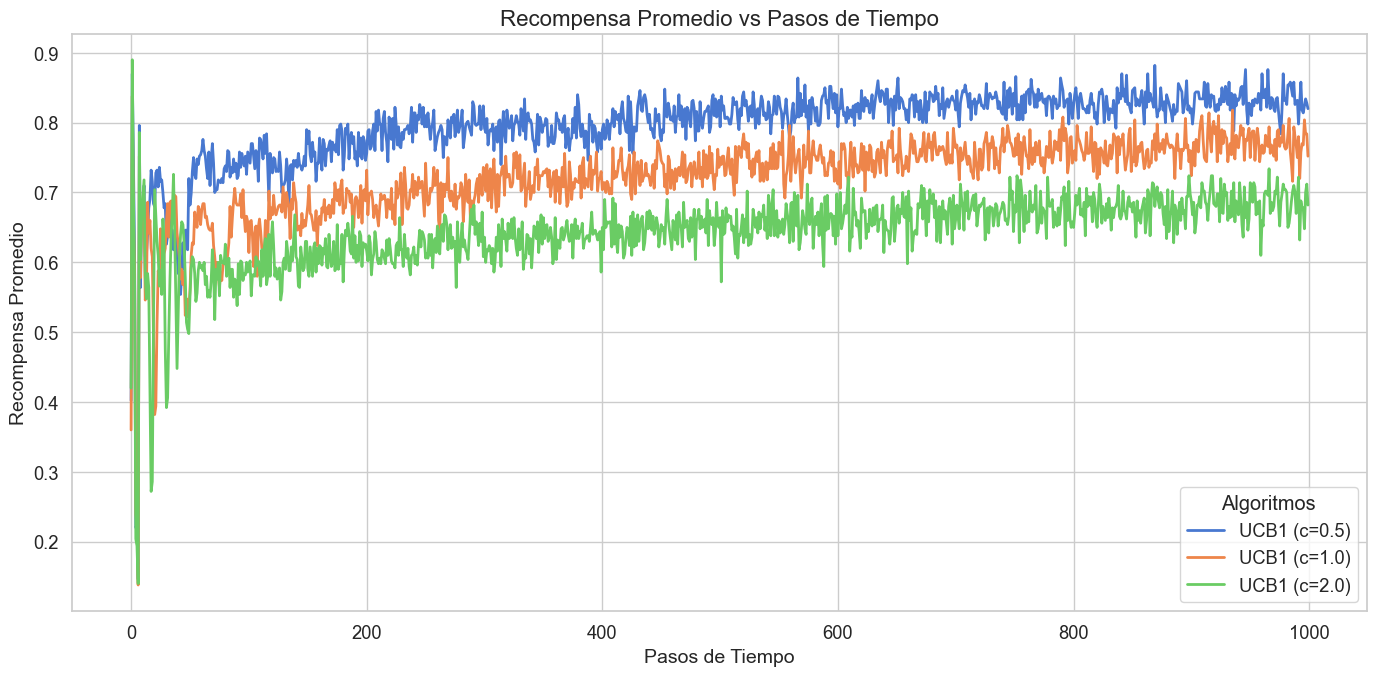

In [20]:
plot_average_rewards(steps, rewards_UCB1, ucb_algorithms)

La gráfica que vemos representa la recompensa promedio obtenida por cada algoritmo en cada paso de tiempo. Los algoritmos utilizados son instancias de la variante UCB1 con diferentes valores de c, parámetro que actúa como ajuste para la exploración. Analizaremos el impacto de dicho valor en los resultados del algoritmo.

Los ejes utilizados son el valor de la recompensa para el eje Y, que en este experimento ha demostrado oscilar entre 0.1 y 0.9, mientras que el eje X corresponde a los pasos de tiempo enumerados de uno en uno, resaltando los valores de 200 y sus múltiplos iniciales hasta el máximo de 1000. Cada paso de este eje representa una iteración en la que se selecciona un brazo y se obtiene una recompensa.

En cuanto a la oscilación tan fuerte visible al principio de los pasos de tiempo, las líneas pueden mostrar una variabilidad significativa en las recompensas promedio. Esto se debe a que los algoritmos están explorando diferentes brazos para recopilar información sobre sus recompensas. La recompensa promedio puede ser baja en esta etapa debido a la exploración de brazos subóptimos, aunque vemos que en ocasiones también alcanzan valores altísimos cuando sobreexplotan el brazo óptimo al ser elegido inicialmente.

**Resultados por algoritmo**
- UCB1 (c=0.5): La línea azul muestra que este algoritmo con un valor de 𝑐=0.5 alcanza la mayor recompensa promedio, estabilizándose alrededor de 0.8. Esto sugiere que un valor más bajo de 𝑐 conduce a una mejor explotación de las recompensas conocidas, resultando en una mayor recompensa promedio.

- UCB1 (c=1.0): La línea naranja representa el algoritmo con 𝑐=1.0. Este algoritmo también logra una buena recompensa promedio, estabilizándose alrededor de 0.7. Aunque no es tan alto como el de 𝑐=0.5, sigue siendo bastante eficiente.

- UCB1 (c=2.0): La línea verde muestra el comportamiento del algoritmo con 𝑐=2.0, el cual alcanza la menor recompensa promedio, estabilizándose alrededor de 0.6. Un valor más alto de 𝑐 introduce más exploración, lo que puede llevar a la selección de opciones subóptimas y, por lo tanto, a una menor recompensa promedio.

La **conclusión** que podemos extraer de esta gráfica es que el primer algoritmo, el de menor valor de c, es el que mejores resultados obtiene y, por tanto, una menor exploración ayuda a obtener una mejor recompensa promedio.

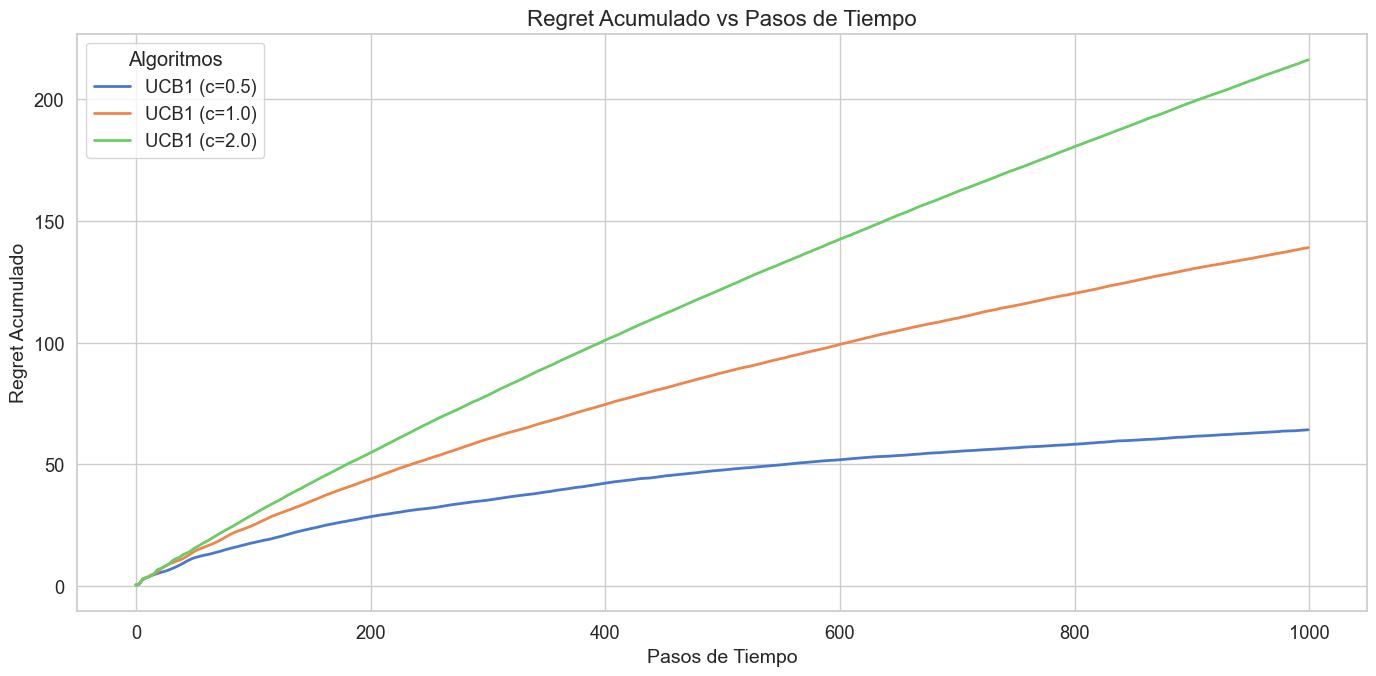

In [21]:
plot_regret(steps, regret_accumulated_UCB1, ucb_algorithms)

El gráfico muestra el rechazo acumulado en función del número de pasos de tiempo para las tres instancias anteriores del algoritmo UCB1. Estos están representados, nuevamente, por cada una de las tres líneas de colores que hemos mostrado en el gráfico anterior.

El eje X vuelve a representar los pasos de tiempo de 0 a 1000, y el eje Y representa el rechazo acumulado, cuyo rango queda comprendido entre 0 y 250 en los resultados visibles.

A nivel general, podemos comentar los siguientes hechos:
- Observamos que todas las líneas tienen una pendiente positiva, lo que indica que el rechazo acumulado aumenta con el tiempo para todas las instancias de UCB1.

- La línea azul (c=0.5) tiene el menor rechazo acumulado en comparación con las otras dos líneas.

- La línea verde (c=2.0) muestra el mayor rechazo acumulado.

- En este experimento, parece que un mayor valor de c lleva a un mayor rechazo acumulado. Esto sugiere que, aunque explorar es importante, un exceso de exploración puede resultar en un mayor rechazo acumulado debido a que el algoritmo podría seleccionar brazos subóptimos con más frecuencia.

**Resultados por algoritmo**
- Línea azul (UCB con c=0.5): Muestra el menor rechazo acumulado, lo que indica que este valor de c proporciona un buen equilibrio entre exploración y explotación.

- Línea naranja (UCB con c=1.0): Muestra un rechazo acumulado mayor que la línea azul, pero menor que la línea verde. Esto indica que con un valor de c intermedio, el algoritmo realiza más exploración que explotación, resultando en un mayor rechazo acumulado.

- Línea verde (UCB con c=2.0): Muestra el mayor rechazo acumulado, lo que sugiere que este valor de c causa demasiada exploración en detrimento de la explotación, lo que lleva a una selección frecuente de brazos subóptimos.

Como **conclusión**, podemos decir que un menor valor del parámetro de exploración c parece ser más beneficioso para reducir el rechazo acumulado. Sin embargo, en algún otro contexto que se pueda presentar, como priorizar la exploración, podría ser beneficioso aumentarlo.